In [2]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np

## Utility fns

In [3]:
def check_orig_files(item):
    
    file_ls = ['orig_file_dis_az', 'orig_file_dis_mag','orig_file_dis_N_ang','orig_file_dis_r']
    
    dt_ls, ref_date_ls, sec_date_ls = [],[],[]
    for file in file_ls:
        
        var_name_dt = f'{file}_datetime'
        var_name_ref = f'{file}_ref_date'
        var_name_sec = f'{file}_sec_date'
        
        var_name_dt = item.extra_fields[file][22:30]
        var_name_ref = item.extra_fields[file].split('+S1_')[1][:15]
        var_name_sec = item.extra_fields[file].split('+S1_')[1].split('_')[9]
        
        dt_ls.append(var_name_dt)
        ref_date_ls.append(var_name_ref)
        sec_date_ls.append(var_name_sec)
       
    if len(set(dt_ls)) != 1:
           print('issue w dt')
    elif len(set(ref_date_ls)) != 1:
             print('issue with ref date')
             
    elif len(set(sec_date_ls)) != 1:
             print('issue w sec date')

In [4]:
def get_footprint(ds):
    ''' returns a geopandas geodataframe with the outline of an xarray object.
    xr object must have crs formatted (ie ds.crs returns epsg code)
    '''
    
    left = ds.x.data.min()
    right = ds.x.data.max()
    bottom = ds.y.data.min()
    top = ds.y.data.max()

    bbox = [left, bottom, right, top]
    
    footprint = Polygon([
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]]
                ])
    
    gdf = gpd.GeoDataFrame(index=[0], crs = ds.crs, geometry = [footprint])
    
    return gdf
    
    

## Read in STAC catalog, explore metadata

In [5]:
catalog = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/retreat/BB310TEST_STAC_CATALOG/catalog.json')

In [6]:
items = list(catalog.get_all_items())

In [7]:
for item in items:
    
    check_orig_files(item)

In [7]:
feature_coll = [item.to_dict() for item in items]

In [8]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)

In [24]:
gdf = gdf.set_crs('EPSG:4326')
gdf_prj = gdf.to_crs('EPSG:32645')

<AxesSubplot: >

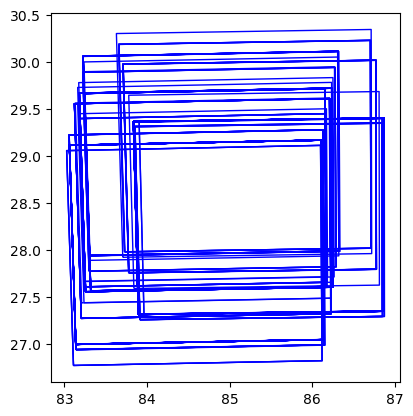

In [10]:
gdf.plot(facecolor='None', edgecolor='blue')

In [19]:
catalog

<Catalog id=NEW RETREAT data, Langtang>

## Explore RETREAT data

In [8]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items])

In [9]:
cube

<xarray.DataArray 'stackstac-14483f5ef45fdd17a8c664a8001ecde7' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time       (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id         (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    site       <U2 '10'
    ...         ...
    frame      (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    sensor     <U2 'S1'
    acq_date   (time) <U15 '20141011T122155' ... '20211030T001931'
    proj:epsg  int64 32645
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [8]:
cube.isel(time=1)

<xarray.DataArray 'stackstac-2d14da1094907268d7b93e7183cd89cd' (band: 5,
                                                                y: 1951, x: 1875)>
dask.array<getitem, shape=(5, 1951, 1875), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
    time       datetime64[ns] 2014-10-31
    id         <U19 '10_019_001_20141031'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    sensor     <U2 'S1'
    ...         ...
    sec_date   <U15 'S1_20141112T001'
    acq_id     <U4 'C51B'
    frame      <U3 '019'
    proj:epsg  int64 32645
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [9]:
cube.isel(time=0).sel(band='dis_mag').mean().compute().data

array(0.02581397)

### Verify against ind file

In [14]:
dismag_10232014 = xr.open_dataset('/home/emmamarshall/Desktop/phd_work/retreat/data/10_085_002/10_085_002_20141023-dis_mag+S1_20141011T122155_8496_1_10_1_10_1_10_S1_20141104T122155_D1BD_1_10_1_10_1_10+250-50_50-10_0.00-0.08_2_geo_filtered_corrected.tif').squeeze()

In [15]:
dismag_10232014.band_data.mean()

<xarray.DataArray 'band_data' ()>
array(0.02581397, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 ...

## Other data

### RGI

In [10]:
rgi_path = '/home/emmamarshall/Desktop/data/rgi/south_asia_east_15/'

In [11]:
rgi15 = gpd.read_file(os.path.join(rgi_path, '15_rgi60_SouthAsiaEast.shp'))

In [12]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [13]:
rgi_ids = pd.read_csv('/home/emmamarshall/Desktop/phd_work/retreat/manuscript_edits/manuscript_rgi_ids.csv', )

lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

In [14]:
rgi_subset = rgi15_prj.loc[rgi15_prj['RGIId'].isin(rgi_ids['RGI_IDs'])]

In [15]:
rgi_lakes = rgi_subset.loc[rgi_subset['RGIId'].isin(lake_ids)]

In [16]:
rgi_lands = rgi_subset.loc[~rgi_subset['RGIId'].isin(lake_ids)]


In [17]:
land_ids = rgi_lands['RGIId'].to_list()


In [18]:
n=8
land_ids_chunked = [land_ids[i*n:(i+1)*n] for i in range((len(land_ids) + n-1) // n)]

In [16]:
land_ids_chunked[0]

['RGI60-15.03976',
 'RGI60-15.04119',
 'RGI60-15.04121',
 'RGI60-15.04176',
 'RGI60-15.04220',
 'RGI60-15.09249',
 'RGI60-15.09255',
 'RGI60-15.09271']

## NASADEM

In [19]:
nasadem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/NASADEM_NC_n28e085.nc').squeeze()

In [20]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [21]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

In [22]:
nasadem_prj_footprint = get_footprint(nasadem_prj)

NameError: name 'gdf_prj' is not defined

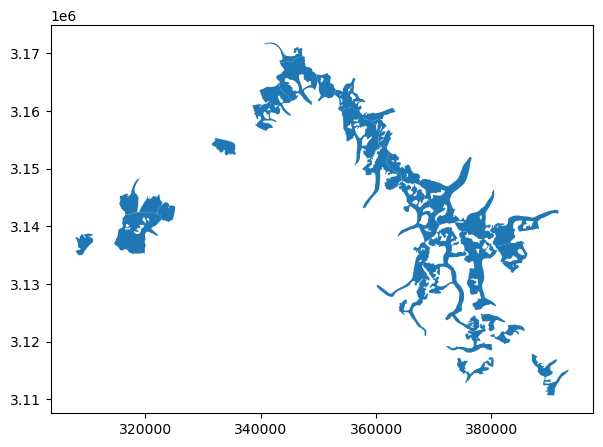

In [23]:
fig, ax = plt.subplots(figsize=(7,7))

#retreat_footprint.plot(ax=ax, facecolor='None', edgecolor='blue')
rgi = rgi_subset.plot(ax=ax, label = 'glacier outlines')
retreat_footprint = gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax, label = 'retreat data footprints')
dem_footprint = nasadem_prj_footprint.plot(facecolor='None', edgecolor='green',ax=ax, label = 'nasadem footprint')


#ax.legend(('RGI','RETREAT','NASADEM'), loc='upper right', shadow=False)
plt.show()

## Ind glacier workflow

### Fns

In [23]:
def clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr): #all in local utm
    
    rgi_single = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    
    retreat_clip = retreat_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    retreat_clip_ds = retreat_clip.to_dataset(dim='band')
    
    dem_clip = dem_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    dem_downsamp = dem_clip.interp_like(retreat_clip_ds, method = 'nearest')
    
    zmin = np.nanmin(dem_downsamp.NASADEM_HGT.data)
    zq1 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 25)
    zmed = np.nanmedian(dem_downsamp.NASADEM_HGT.data)
    zq3 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 75)
    zmax = np.nanmax(dem_downsamp.NASADEM_HGT.data)
    
    z0 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmin, dem_downsamp.NASADEM_HGT <= zq1), drop=True)
    z1 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq1, dem_downsamp.NASADEM_HGT <= zmed), drop=True)
    z2 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmed, dem_downsamp.NASADEM_HGT <= zq3), drop=True)
    z3 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq3, dem_downsamp.NASADEM_HGT <= zmax), drop=True)
    
    retreat_clip_ds['z0'] = z0
    retreat_clip_ds['z1'] = z1
    retreat_clip_ds['z2'] = z2
    retreat_clip_ds['z3'] = z3
    
    z0_cond_min = retreat_clip_ds.z0.min().data >= zmin
    z0_cond_max = retreat_clip_ds.z0.max().data < zq1+1
    z1_cond_min = retreat_clip_ds.z1.min().data >= zq1
    z1_cond_max = retreat_clip_ds.z1.max().data <zmed + 1
    z2_cond_min = retreat_clip_ds.z2.min().data >= zmed
    z2_cond_max = retreat_clip_ds.z2.max().data < zq3 + 1
    z3_cond_min = retreat_clip_ds.z3.min().data >= zq3
    z3_cond_max = retreat_clip_ds.z3.max().data < zmax+1
    
    cond_ls = [z0_cond_min, z0_cond_max, z1_cond_min, z1_cond_max,
               z2_cond_min, z2_cond_max, z3_cond_min, z3_cond_max]
    
    test = all(i for i in cond_ls)
    
    if test != True:
        
        print('there is an elevation masking issue here')
        
    else:
    
        pass
    
        return retreat_clip_ds

In [24]:
def calc_seasonal_mean_by_z(input_ds, z, var, rgi_id):
        
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    
    if z == 'full':
        
        winter = gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
        
    else:
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)

        winter = z_gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = z_gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = z_gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = z_gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
    
    d = {'RGIId':rgi_id, 'z':z, 'winter': winter,
         'spring':spring, 'summer':summer, 'fall':fall}
    df = pd.DataFrame(d, index=[0])
    
    return df
    

In [25]:
ds_03976 = clip_glacier_add_dem('RGI60-15.03976', rgi_subset, cube, nasadem_prj)
ds_03976

<xarray.Dataset>
Dimensions:      (time: 314, x: 15, y: 19, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    site         <U2 '10'
    tile         (time) <U10 '10_085_002' '10_019_001' ... '10_019_085'
    ...           ...
    acq_date     (time) <U15 '20141011T122155' ... '20211030T001931'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    z0           (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    z1           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z2           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z3           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [29]:
#import zarr

In [30]:
#ds_03976.to_zarr('/home/emmamarshall/Desktop/phd_work/retreat/test_data/rgi03976_ds.nc')

In [50]:
groupby_03976 = ds_03976.groupby(ds_03976.time.dt.season).mean()

checking by hand to make sure its all good -- it is, function df below should be correct

In [52]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

43.500089049598614
56.47553117056695
39.54093994895913
37.496375544561175


In [37]:
dismag_03976 = pd.concat([calc_seasonal_mean_by_z(ds_03976, z,'dis_mag','RGI60-15.03976') for z in ['z0','z1','z2','z3','full']])


In [22]:
def wrapper_single_glacier(rgi_id, rgi_full, retreat_xr, dem_xr, var):
    '''wraps the above two functions, returns a dataframe with seasonal velocities for each elevation quartile
       input args are: rgi_id (str), full or subset rgi gpdf
       retreat xr object (read from stackstac) in local utm,
       NASADEM xr object projected to local utm 
       variable for which you want seasonal means to be calculated
       
   '''
    ds = clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)
    
    df = pd.concat([calc_seasonal_mean_by_z(ds, z, var, rgi_id) for z in ['z0','z1','z2','z3','full']])

    return df

In [55]:
df_03976 = wrapper_single_glacier('RGI60-15.03976', rgi_subset, cube, nasadem_prj, 'dis_mag')

In [30]:
df_lakes = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in lake_ids])

In [25]:
df_lands_chunk0 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[0]])

In [26]:
df_lands_chunk1 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[1]])

In [23]:
df_lands_chunk2 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[2]])

In [27]:
#df_lands_chunk3 = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in land_ids_chunked[3]])
#df_lands_chunk3.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/310_seasonal_velocities_LANDS_3.csv')

In [32]:
df_lakes.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/310_seasonal_velocities_LAKES.csv')

In [27]:
df_lands_chunk1.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/310_seasonal_velocities_LANDS_1.csv')

## Time series analysis

### Going back and calculating SEM when calculating mean at each time step

- this doesn't seem to work with `.reduce()` because sem() needs a flattened array, but xarray `.map()` doesn't recognize numpy flatten, i think because it is a np.ndarray method instead of a fn? 
- seems like it should be easy to do this but not working the above method. I think may need to use ufunc?... try tomorrow

In [31]:
from scipy.stats import sem

In [32]:
a = (ds_03976.isel(time=1).dis_mag*365).compute()

In [33]:
a_f = a.data.flatten()
sem(a_f, nan_policy='omit')

2.351500320897391

In [47]:
def calc_sem(x):
    
    return sem(x.flatten, nan_policy='omit')

In [51]:
sample_flatten = ds_03976.dis_mag.reduce(np.flatten).reduce(sem)

AttributeError: module 'numpy' has no attribute 'flatten'

In [25]:
ds_03976.isel(time=1).dis_mag.mean().compute()

<xarray.DataArray 'dis_mag' ()>
array(0.10754856)
Coordinates: (12/15)
    time         datetime64[ns] 2014-10-31
    id           <U19 '10_019_001_20141031'
    acq_id       <U4 'C51B'
    sec_id       <U4 '54_1'
    site         <U2 '10'
    tile         <U10 '10_019_001'
    ...           ...
    sensor       <U2 'S1'
    sec_date     <U15 'S1_20141112T001'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

### want to make dict where each key is id of a lake or land term glacier, value is the prepared xr object for that glacier
eventually, want to plot scatter plot of mean velocity along time series w/ term type indicated by color

clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)

In [27]:
lake_vals = [clip_glacier_add_dem(rgi_id, rgi_lakes, cube, nasadem_prj) for rgi_id in lake_ids]

lakes_dict = dict(zip(lake_ids, lake_vals))

In [28]:
land_vals0 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[0]]
land_vals1 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[1]]
land_vals2 = [clip_glacier_add_dem(rgi_id, rgi_lands, cube, nasadem_prj) for rgi_id in land_ids_chunked[2]]

In [29]:
lands_dict0 = dict(zip(land_ids_chunked[0], land_vals0))
lands_dict1 = dict(zip(land_ids_chunked[1], land_vals1))
lands_dict2 = dict(zip(land_ids_chunked[2], land_vals2))

In [42]:
df_test = (lakes_dict['RGI60-15.10255'].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name='RGI60-15.10255')

In [44]:
df_test1 = (lakes_dict['RGI60-15.10279'].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name='RGI60-15.10279')

In [30]:
from functools import reduce

def make_timeseries_dfs(glacier_dict):
    
    df_ls = []
    
    for key in glacier_dict.keys():
        
        df = (glacier_dict[key].dis_mag*365).mean(dim=['x','y']).to_pandas().to_frame(name=key)
        df_ls.append(df)
    
    #df_merge = reduce(lambda x,y: pd.merge(x,y, left_index=True, right_index=True), df_ls)
    
    return df_ls

In [31]:
lakes_df = make_timeseries_dfs(lakes_dict)

In [46]:
lands_df2 = make_timeseries_dfs(lands_dict2)

In [47]:
lands_merge2 = pd.concat(lands_df2, axis=1)

In [48]:
lands_merge2.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lands2_timeseries.csv')

In [33]:
lakes_merge = pd.concat(lakes_df, axis=1)

In [43]:
lakes_merge.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lakes_timeseries.csv')

In [60]:
lakes_merge = reduce(lambda left, right:
                     pd.merge(left, right,
                              on = ['time'],
                              how='outer'), lakes_df)

In [61]:
lakes_merge

time  RGI60-15.10255  RGI60-15.10285  RGI60-15.10279  \
0    2014-10-23       37.203957       39.713746       50.085530   
1    2014-10-31       28.964534       17.907510       31.039654   
2    2014-11-12       29.058171       19.757956       33.685889   
3    2014-11-16       35.539512       26.894478       50.807094   
4    2014-11-24       21.729068       15.255470       34.266613   
...         ...             ...             ...             ...   
2341 2021-06-26       39.531412       28.751725       34.436997   
2342 2021-07-08       35.726866       23.602421       30.609747   
2343 2021-07-20       54.561694       44.832589       39.923152   
2344 2021-10-12       31.103528       15.759601       46.264603   
2345 2021-11-05       57.895610       26.204849       38.844254   

      RGI60-15.10286  RGI60-15.09361  RGI60-15.09483  RGI60-15.10290  \
0          31.326510       22.745448       27.586156       31.313938   
1          15.289765       19.073190       18.614763       30.692453   
2          24.287812       19.551552       21.494565       27.397770   
3          28.294911       20.392088       31.007556       25.840200   
4          14.412342       16.317761       17.675166       21.581679   
...              ...             ...             ...             ...   
2341       26.266036       20.002539       33.463584       40.550072   
2342       18.274515       16.643682       20.199530       33.390791   
2343       24.978611       17.353285       20.281428       37.409335   
2344       17.326726       39.263672       27.255563       27.439329   
2345       19.175592       23.195678       21.533689       38.497062   

      RGI60-15.10299  
0          32.600996  
1          31.932766  
2          33.324615  
3          27.299566  
4          26.380294  
...              ...  
2341       38.323948  
2342       36.534269  
2343       48.723313  
2344       35.721180  
2345       31.811272  

[2346 rows x 9 columns]

In [45]:
lakes_df[1].index == lakes_df[2].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [38]:
lakes_df[0]

RGI60-15.10255
time                      
2014-10-23       37.203957
2014-10-31       28.964534
2014-11-12       29.058171
2014-11-16       35.539512
2014-11-24       21.729068
...                    ...
2021-06-26       39.531412
2021-07-08       35.726866
2021-07-20       54.561694
2021-10-12       31.103528
2021-11-05       57.895610

[314 rows x 1 columns]

In [29]:
lakes_df.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lakes_timeseries.csv')

In [30]:
lands_df0 = make_timeseries_dfs(lands_dict0)

In [34]:
lands_df2 = make_timeseries_dfs(lands_dict2)

In [35]:
lands_df2.to_csv('/home/emmamarshall/Desktop/phd_work/retreat/311_lands2_timeseries.csv')

In [48]:
df_merge = pd.merge([df_test, df_test1], left_index=True, right_index=True)

TypeError: merge() missing 1 required positional argument: 'right'

In [47]:
df_merge

RGI60-15.10255  RGI60-15.10279
time                                      
2014-10-23       37.203957       50.085530
2014-10-31       28.964534       31.039654
2014-11-12       29.058171       33.685889
2014-11-16       35.539512       50.807094
2014-11-24       21.729068       34.266613
...                    ...             ...
2021-06-26       39.531412       34.436997
2021-07-08       35.726866       30.609747
2021-07-20       54.561694       39.923152
2021-10-12       31.103528       46.264603
2021-11-05       57.895610       38.844254

[330 rows x 2 columns]

In [41]:
df_test

mean_velocity          RGI_ID
time                                     
2014-10-23      37.203957  RGI60-15.10255
2014-10-31      28.964534  RGI60-15.10255
2014-11-12      29.058171  RGI60-15.10255
2014-11-16      35.539512  RGI60-15.10255
2014-11-24      21.729068  RGI60-15.10255
...                   ...             ...
2021-06-26      39.531412  RGI60-15.10255
2021-07-08      35.726866  RGI60-15.10255
2021-07-20      54.561694  RGI60-15.10255
2021-10-12      31.103528  RGI60-15.10255
2021-11-05      57.895610  RGI60-15.10255

[314 rows x 2 columns]

In [49]:
#for key in lakes_dict.keys():
   # print(key)

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))

for key in lakes_dict.keys():
    
    (lakes_dict[key].dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None', ax=ax, color='blue')

for key in lands_dict.keys():
    
    (lands_dict[key].dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None', ax=ax, color='red')

    

In [46]:
lands_dict['RGI60-15.04119']

<xarray.Dataset>
Dimensions:      (time: 314, x: 27, y: 53, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
  * x            (x) float64 3.64e+05 3.642e+05 3.644e+05 ... 3.69e+05 3.692e+05
  * y            (y) float64 3.131e+06 3.131e+06 ... 3.121e+06 3.121e+06
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
    sensor       <U2 'S1'
    frame        (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    ...           ...
    acq_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 53, 27), meta=np.ndarray>
    z0           (y, x) float32 nan nan nan nan nan ... 4.188e+03 nan nan nan
    z1           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z2           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    z3           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

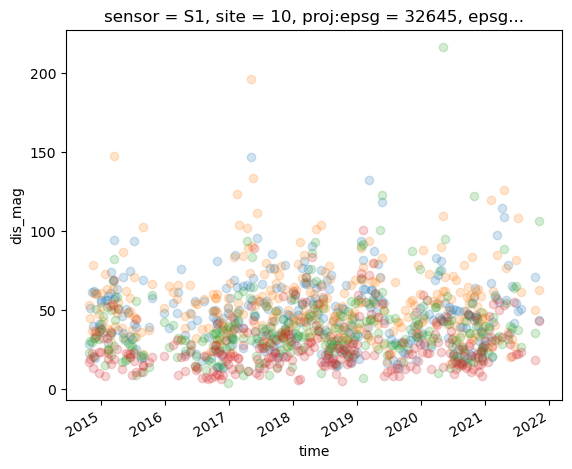

In [39]:
(ds_03976.where(ds_03976.z0.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z1.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z2.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')
(ds_03976.where(ds_03976.z3.notnull(), drop=True).dis_mag*365).mean(dim=['x','y']).plot(alpha=0.2, marker='o', linestyle='None')

In [411]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

49.01688174578074
58.84126650363933
52.13552099430868
48.82556403973669


In [361]:
print(retreat_03976_ds.where(retreat_03976_ds.z0.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z1.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z2.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z3.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)

45.30674327578146
52.206323957787
36.01065521264687
26.98912238155708


In [338]:
z0_ds = xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds, np.nan)
z1_ds = xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds, np.nan)
z2_ds = xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds, np.nan)
z3_ds = xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds, np.nan)



In [344]:
z0_new = z0_ds.where(z0_ds.z0.notnull(), drop=True)
z1_new = z1_ds.where(z1_ds.z1.notnull(), drop=True)
z2_new = z2_ds.where(z2_ds.z2.notnull(), drop=True)
z3_new = z3_ds.where(z3_ds.z3.notnull(), drop=True)

In [348]:
z0_new.x.max()

<xarray.DataArray 'x' ()>
array(309400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [349]:
z1_new.x.min()

<xarray.DataArray 'x' ()>
array(308400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [347]:
ds_full = xr.combine_by_coords([z0_new, z1_new, z2_new, z3_new])

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

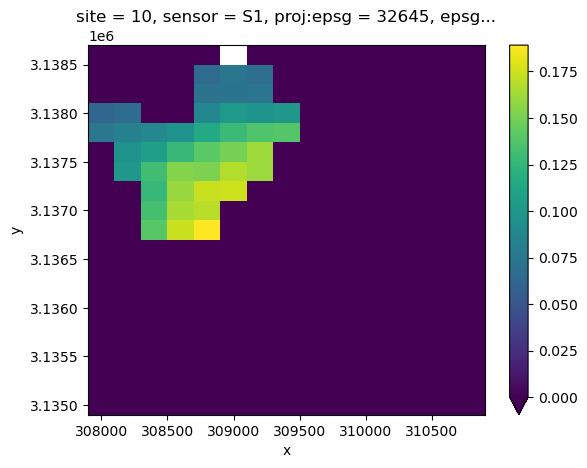

In [307]:
z0_vv.mean(dim='time').plot(vmin=0)

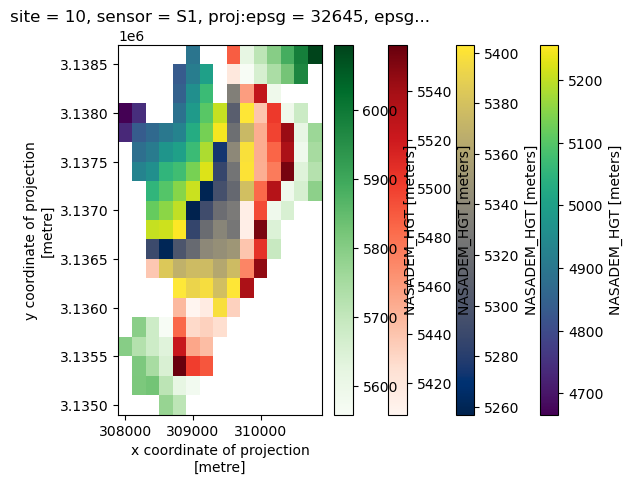

In [271]:
fig, ax = plt.subplots()
retreat_03976_ds.z0.plot(ax=ax)
retreat_03976_ds.z1.plot(ax=ax, cmap='cividis')
retreat_03976_ds.z2.plot(ax=ax, cmap='Reds')
retreat_03976_ds.z3.plot(ax=ax, cmap='Greens')

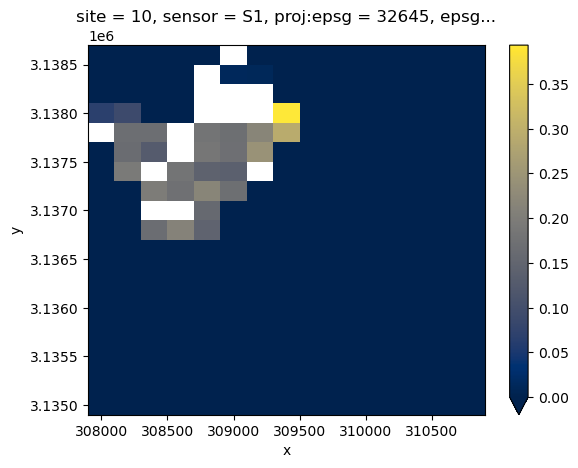

In [298]:
fig, ax = plt.subplots()
xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=4).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0)
#xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')



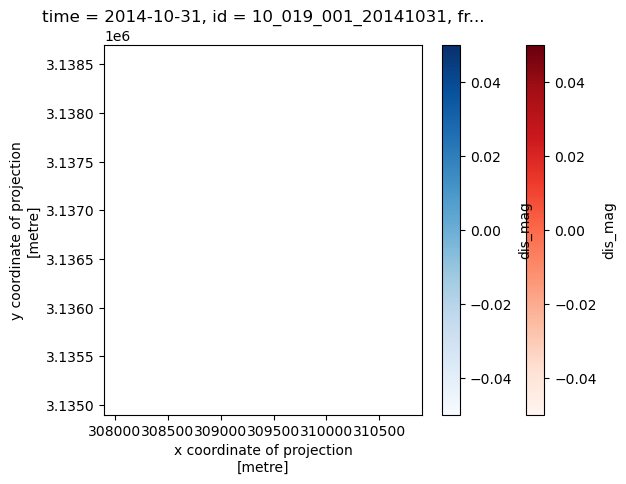

In [281]:
fig, ax = plt.subplots()
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z1 < 0).dis_mag.plot(ax=ax, cmap='Reds')
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z2 < 0).dis_mag.plot(ax=ax, cmap='Blues')

In [261]:
retreat_03976_ds.z0.plot(ax=ax)


In [239]:
z1 = dem_03976_downsamp.NASADEM_HGT.where(np.logical_and(dem_03976_downsamp.NASADEM_HGT >= 5256.25, dem_03976_downsamp.NASADEM_HGT <= 5405.), drop=True)


In [72]:
retreat_03976['z'] = (('y','x'), dem_03976_downsamp.NASADEM_HGT.data)

In [215]:
retreat_03976_ds

<xarray.Dataset>
Dimensions:      (time: 314, y: 19, x: 15, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    frame        (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    ...           ...
    sec_date     (time) <U15 'S1_20141104T122' ... '20211111T001930'
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    z            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [221]:
np.nanpercentile(retreat_03976_ds.z.data, 50)

5405.0

In [220]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.max()

<xarray.DataArray 'z' ()>
array(5536., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

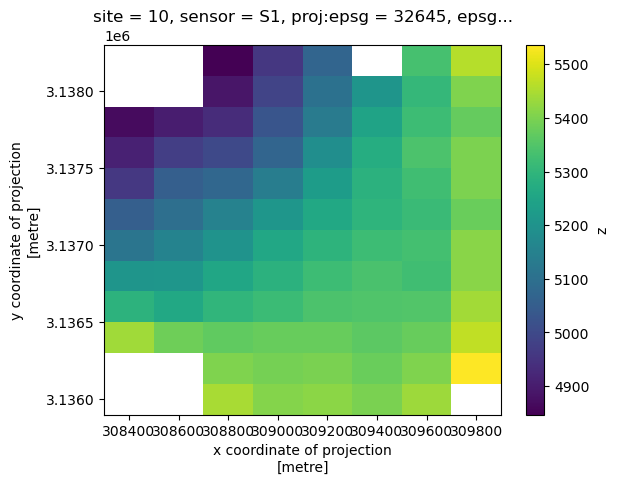

In [223]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.plot()

In [207]:
z0_condition = retreat_03976_ds.z <= 5256.25

In [208]:
z0_subset = retreat_03976_ds.sel(z = z0_condition)

KeyError: "no index found for coordinate 'z'"

In [192]:
zmin = np.nanmin(retreat_03976['z'].data)
zq1 = np.nanpercentile(retreat_03976['z'].data, 25)
zmed = np.nanmedian(retreat_03976['z'].data)
zq3 = np.nanpercentile(retreat_03976['z'].data, 75)
zmax = np.nanmax(retreat_03976['z'].data)

print(zmin)
print(zq1)
print(zmed)
print(zq3)
print(zmax)
    
#define z groups
z_group0 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= zmin, retreat_03976_ds.z < 5337), drop=True)
#z_group1 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5256.25, retreat_03976_ds.z <= 5405.), drop=True)
#z_group2 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5405, retreat_03976_ds.z <= 5559.), drop=True)
#z_group3 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5559., retreat_03976_ds.z <= zmax), drop=True)

4666.0
5256.25
5405.0
5559.0
6094.0


In [193]:
z_group0.z.max()

<xarray.DataArray 'z' ()>
array(5488., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

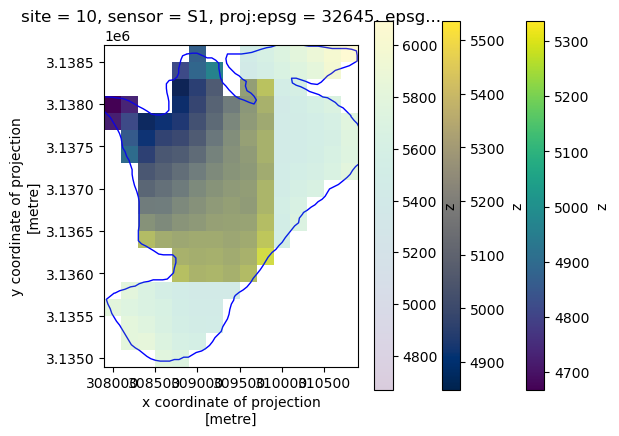

In [187]:
fig, ax = plt.subplots()

z_group0.z.plot(ax=ax)

z_group1.z.plot(ax=ax, cmap='cividis')

rgi_03976.plot(ax=ax, facecolor='None', edgecolor='Blue')
retreat_03976_ds.z.plot(ax=ax, alpha = 0.2)

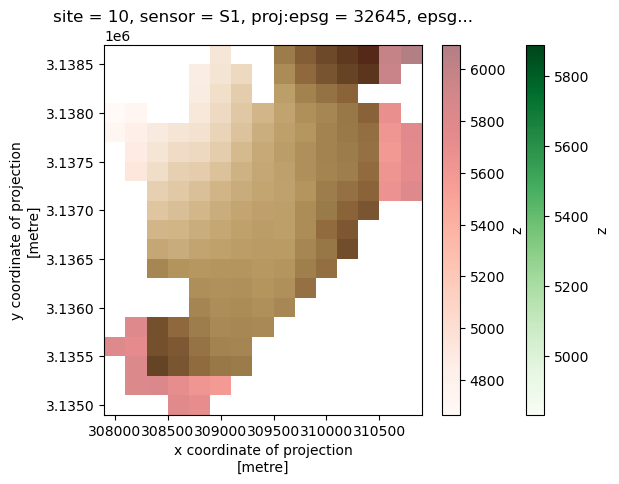

In [161]:
fig, ax = plt.subplots() 

retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5405, retreat_03976_ds.z <= 5559), drop=True).z.plot(ax=ax, cmap='Greens')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5256.25, retreat_03976_ds.z <= 5405), drop=True).z.plot(ax=ax, cmap='cividis')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 4666., retreat_03976_ds.z <= 5256.25), drop=True).z.plot(ax=ax)

retreat_03976_ds.z.plot( alpha = 0.5, ax=ax, cmap='Reds')


In [78]:
import numpy as np
np.nanmedian(retreat_03976.z)

5405.0

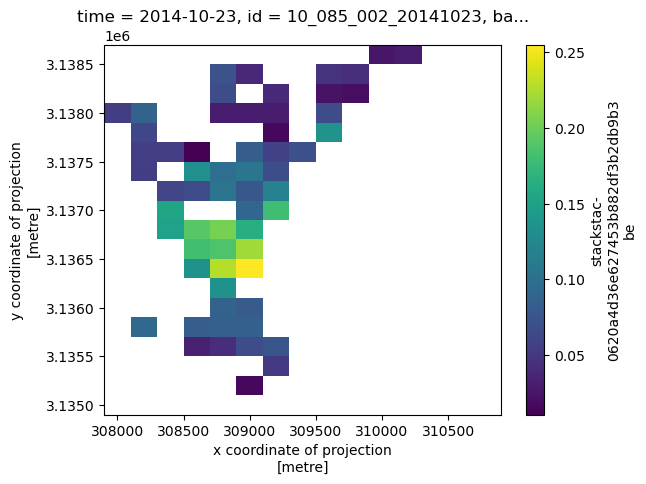

In [52]:
retreat_03976.isel(time=0).sel(band='dis_mag').plot()